# Projet Quantification d'Incertitudes
## Propragation du coronavirus MERS-CoV en Corée du Sud

In [1]:
import openturns as ot

## Modèle probabiliste

Lois marginales de : 
$\beta_{ini}$ ~ $B(5.5,5.5,0.215,0.248$,
$\nu$ ~ $G(7.3, 975, 0.021)$, 
$I(0)$ ~ $B(2,5,1,3)$, 
$N(0)$ ~ $U(50950000, 51050000)$.

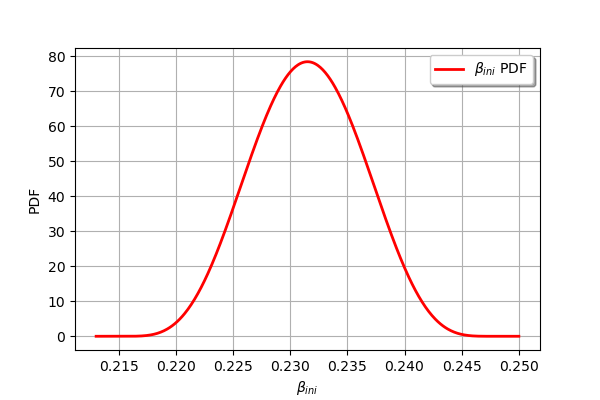

In [2]:
#À mettre en commentaire si besoin, set de certains paramètres
ot.ResourceMap.SetAsUnsignedInteger("Distribution-DefaultPointNumber", 512)
ot.PlatformInfo.SetNumericalPrecision(4)


beta_ini = ot.Beta(5.5,5.5,0.215,0.248)
beta_ini.setDescription([r"$\beta_{ini}$"])
beta_ini.drawPDF()

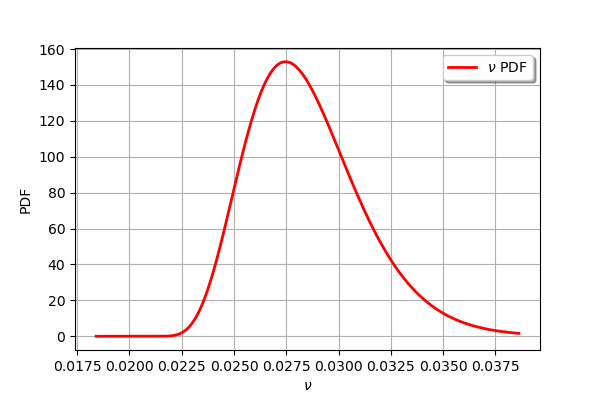

In [3]:
nu = ot.Gamma(7.3, 975, 0.021)
nu.setDescription([r"$\nu$"])
nu.drawPDF()

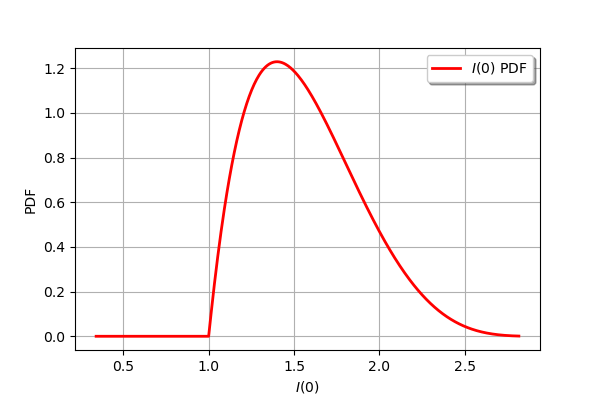

In [4]:
I0 = ot.Beta(2,5,1,3)
I0.setDescription([r"$I(0)$"])
I0.drawPDF()

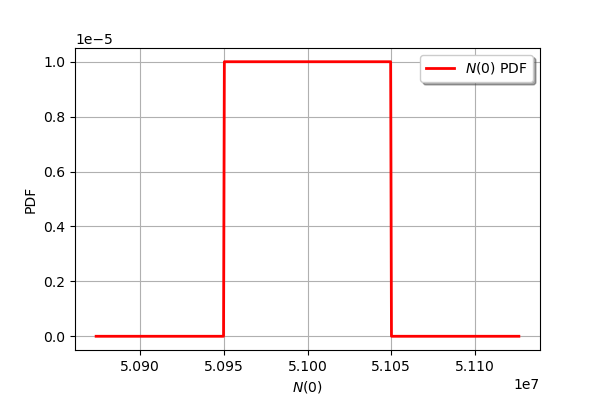

In [5]:
N0 = ot.Uniform(50950000,51050000)
N0.setDescription([r"$N(0)$"])
N0.drawPDF()

On note la variable $R_0 = \frac{\beta_{ini}}{\nu}$. Tracer sa densité de probabilité. Commenter sur la possibilité d'une extinction spontanée de l'épidémie.

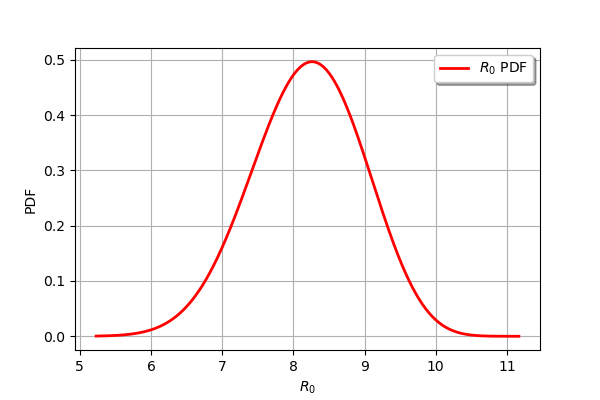

In [6]:
R0 = beta_ini / nu
R0.setDescription([r"$R_0$"])
R0.drawPDF()

Il faudrait que $R_0 < 1$ pour obtenir une extinction spontanée de l'épidémie. Hors ici, la la densité est centré un peu au dessus de 8, il y a peu de chance qu'une extinction spontanée arrive.

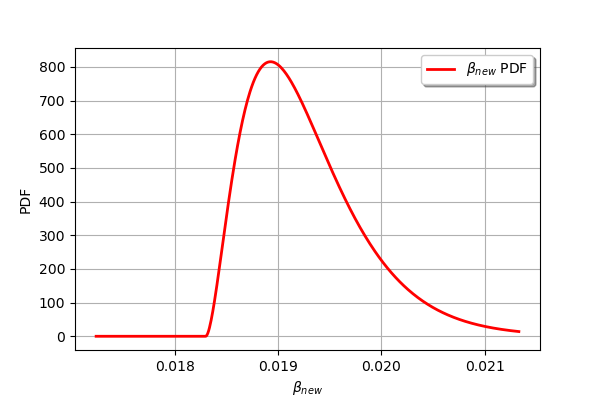

In [7]:
beta_new = ot.Gamma(2.8, 2870, 0.0183)
beta_new.setDescription([r"$\beta_{new}$"])
beta_new.drawPDF()

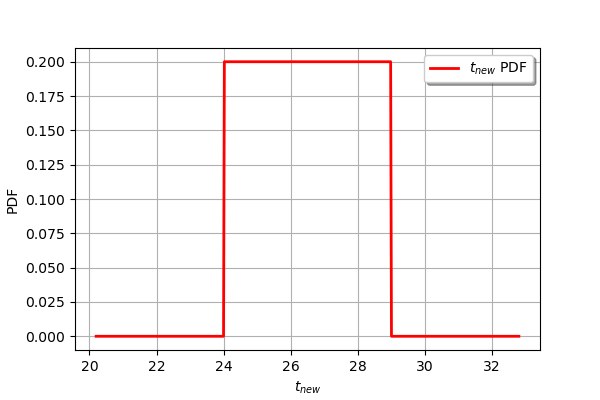

In [8]:
t_new = ot.Uniform(24,29)
t_new.setDescription([r"$t_{new}$"])
t_new.drawPDF()

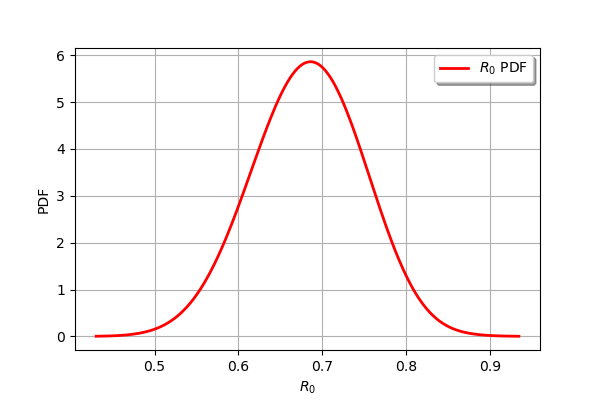

In [9]:
R0 = beta_new / nu
R0.setDescription([r"$R_0$"])
R0.drawPDF()

Sous cette configuration, la répartition des valeurs de la loi de $R_0$ se trouve autour de 0.7 et on peut espérer l'extinction de l'épidémie.

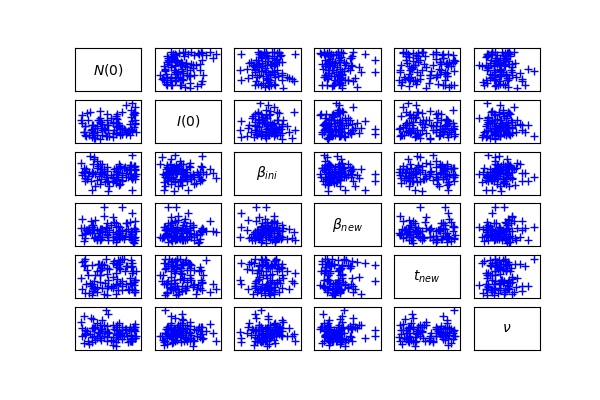

In [10]:
marginales = [N0, I0, beta_ini, beta_new, t_new, nu]
dist_X = ot.ComposedDistribution(marginales)
ot.Pairs(dist_X.getSample(100))

In [11]:
X = ot.RandomVector(dist_X)

## Création de la variable d'intérêt 

In [12]:
# Set the ODE solver parameters
ot.ResourceMap.SetAsScalar("Fehlberg-InitialStep", 1.0e-1)
ot.ResourceMap.SetAsScalar("Fehlberg-LocalPrecision", 1.0e-6)
ot.ResourceMap.SetAsUnsignedInteger("Fehlberg-DefaultOrder", 4)

def buildFunction(beta, nu, N, t0):
    '''
       Build the transition function of the SIR model given the values of
       beta and nu
    '''
    f = ot.SymbolicFunction(['t', 'S', 'I', 'R'], [str(-beta/N)  + '*S*I', str(beta/N) + 'S*I-' + str(nu) + '*I', str(nu) + '*I'])
    phi = ot.ParametricFunction(f, [0], [t0])
    return phi

In [13]:
def computeMax(X):
    '''
       Compute the maximum number of people in group I over [0,T]
       Note: the ODE is integrated using an adaptive method, and the
       measurement is done with a time step of one hour
    '''
    dt = 1.0 / 24.0
    N0 = X[0]
    I0 = X[1]
    betaIni = X[2]
    betaNew = X[3]
    tNew = X[4]
    nu = X[5]
    # First phase, no intervention
    phi = buildFunction(betaIni, nu, N0, 0.0)
    solver = ot.Fehlberg(phi)
    initialState = [N0-I0, I0, 0.0]
    nt = int(tNew / dt) + 1
    dt = tNew / (nt - 1)
    grid = ot.RegularGrid(0.0, dt, nt).getVertices().asPoint()
    result = solver.solve(initialState, grid)
    # Extract the maximum number of infected people in phase 0
    max0 = result.getMax()[1]
    # Second phase, after intervention
    phi = buildFunction(betaNew, nu, N0, tNew)
    solver = ot.Fehlberg(phi)
    initialState = result[-1]
    grid = ot.RegularGrid(tNew, dt, int(300 / dt + 1)).getVertices().asPoint()
    result = solver.solve(initialState, grid)
    # Extract the maximum number of infected people in phase 1
    max1 = result.getMax()[1]
    return [max(max0, max1)]

In [14]:
f = ot.PythonFunction(6,1,computeMax)
Y = ot.CompositeRandomVector(f, X)

In [15]:
#echantillonY = Y.getSample(10000)

In [16]:
distY = ot.KernelSmoothing().build(echantillonY)
personne = distY.getMean()[0]
print("Moyenne max de personnes = ", personne)
sigma = distY.getStandardDeviation()[0]
print("Ecart-type du max de personnes = ", sigma)
distY.drawPDF()

NameError: name 'echantillonY' is not defined

In [17]:
echantillonY.exportToCSVFile('echantillonY.csv', ';')

NameError: name 'echantillonY' is not defined

## Calcul de probabilité d'évènements rares

In [18]:
print("Capacité d'accueil critique")
E = ot.ThresholdEvent(Y, ot.Greater(), 1000)
algo = ot.FORM(ot.Cobyla(), E, X.getMean())
n0E = f.getEvaluationCallsNumber()
algo.run()
result = algo.getResult()
print("FORM(E)=%.2e" % result.getEventProbability())
n1E = f.getEvaluationCallsNumber()
print("Evals = ", n1E - n0E)

Capacité d'accueil critique
FORM(E)=1.56e-03
Evals =  113


La probabilité que le nombre de lits soient insuffisant au cours de l'épidémie est faible.

In [19]:
Nest = int(100 / result.getEventProbability())
print("Nombre de simulations estimé=%.2e" % Nest)

Nombre de simulations estimé=6.40e+04


In [20]:
algo = ot.ProbabilitySimulationAlgorithm(E, ot.MonteCarloExperiment())
algo.setMaximumOuterSampling(1000)
algo.setBlockSize(100)
algo.run()

In [21]:
result = algo.getResult()
print("Variation de l'estimateur = %.2e" % result.getVarianceEstimate())

Variation de l'estimateur = 6.96e-09


La probabilité de ne pas pouvoir accueillir les personnes infectées est quasi nulle.

In [97]:
r = ot.Beta(2,4,0.9,1.2)
r.setDescription([r"$r$"])

marginal_xtilde = list(marginales)
marginal_xtilde.append(r)
dist_xtilde = ot.ComposedDistribution(marginal_xtilde)
Xtilde = ot.RandomVector(dist_xtilde)

In [98]:
def buildFunctionFuzzy(beta, nu, N, t0,r):
    '''
       Build the transition function of the SIR model given the values of
       beta and nu
    '''
    f = ot.SymbolicFunction(['t', 'S', 'I', 'R'], [str(r) + "*(" + str(-beta/N)  + '*S*I)', str(r) + "*(" + str(beta/N) + 'S*I-' + str(nu) + '*I)', str(r) + '*(' + str(nu) + '*I)'])
    phi = ot.ParametricFunction(f, [0], [t0])
    return phi

In [99]:
def computeMaxFuzzy(X):
    '''
       Compute the maximum number of people in group I over [0,T]
       Note: the ODE is integrated using an adaptive method, and the
       measurement is done with a time step of one hour
    '''
    dt = 1.0 / 24.0
    N0 = X[0]
    I0 = X[1]
    betaIni = X[2]
    betaNew = X[3]
    tNew = X[4]
    nu = X[5]
    r = X[6]
    # First phase, no intervention
    phi = buildFunctionFuzzy(betaIni, nu, N0, 0.0, r)
    solver = ot.Fehlberg(phi)
    initialState = [N0-I0, I0, 0.0]
    nt = int(tNew / dt) + 1
    dt = tNew / (nt - 1)
    grid = ot.RegularGrid(0.0, dt, nt).getVertices().asPoint()
    result = solver.solve(initialState, grid)
    # Extract the maximum number of infected people in phase 0
    max0 = result.getMax()[1]
    # Second phase, after intervention
    phi = buildFunctionFuzzy(betaNew, nu, N0, tNew, r)
    solver = ot.Fehlberg(phi)
    initialState = result[-1]
    grid = ot.RegularGrid(tNew, dt, int(300 / dt + 1)).getVertices().asPoint()
    result = solver.solve(initialState, grid)
    # Extract the maximum number of infected people in phase 1
    max1 = result.getMax()[1]
    return [max(max0, max1)]

In [100]:
ftilde = ot.PythonFunction(7,1,computeMaxFuzzy)
Ytilde = ot.CompositeRandomVector(ftilde, Xtilde)

In [101]:
Etilde = ot.ThresholdEvent(Ytilde, ot.Greater(), 1000)

In [102]:
algo = ot.FORM(ot.Cobyla(), Etilde, Xtilde.getMean())
algo.run()
result = algo.getResult()
print("FORM(Etilde)=%.2e" % result.getEventProbability())

FORM(Etilde)=2.43e-02


## Analyse de sensibilité

In [103]:
ot.ResourceMap.SetAsString('SobolIndicesExperiment-SamplingMethod', 'QMC')

In [110]:
dimension = dist_xtilde.getDimension()
size = 4096
inputDesign = ot.SobolIndicesExperiment(dist_xtilde,size).generate()
outputDesign = ftilde(inputDesign)

In [130]:
# analyse de sensibilité
# indice de Sobol
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign,outputDesign,size)
print('Indice de Sobol du premier ordre = (%)')
print(sensitivityAnalysis.getFirstOrderIndices())

print('\n Indice de Sobol totaux du premier ordre = (%)')
print(sensitivityAnalysis.getTotalOrderIndices())

Indice de Sobol du premier ordre = (%)
[-0.002328,0.1475,0.06291,-0.002328,0.3085,0.01651,0.3623]

 Indice de Sobol totaux du premier ordre = (%)
[1.324e-10,0.1811,0.07943,-1.414e-11,0.3844,0.02636,0.4355]


In [ ]:
# esperance conditionnel
size = 10000
sample_X = Xtilde.getSample(size)